In [1]:
import os
from ordereddict import OrderedDict
os.environ['THEANO_FLAGS']="device=cpu"

from utils import tile_raster_images
from pylearn2.utils import serial
import theano
import theano.tensor as T

try:
    import PIL.Image as Image
except ImportError:
    import Image
import IPython.display as I

In [3]:
DIR_DATA = '/Users/vmisra/data/AE_experiments'
dir_model = os.path.join(DIR_DATA,'models')
dir_fuel = os.path.join(DIR_DATA,'fuel')

#Load models and data

In [4]:
test_data = serial.load(os.path.join(dir_fuel,'mnist_test_X.pkl'))

In [6]:
model_folders = [model_folder \
               for model_folder in os.listdir(dir_model) \
               if os.path.isdir(os.path.join(dir_model,model_folder))]
model_folders = ['B16','B17','B18','B19','B20']
submodels = ['0.pkl','1.pkl','2.pkl','3.pkl']
final_model='finetune.pkl'
submodel_set = submodels+[final_model]

In [7]:
def get_outputs(models, submodels=None, finetuned=None):
    xhat = OrderedDict()
    if submodels != None:
        for (idx,submodel) in enumerate(submodels):
            X = models[submodel].get_input_space().make_theano_batch()
            Y = X
            for jdx in range(idx+1):
                Y = models[submodels[jdx]].encode(Y)
            for jdx in range(idx+1)[::-1]:
                Y = models[submodels[jdx]].decode(Y)
            xhat[submodel] = Y.eval({X:test_data})
    if finetuned != None:
        X = models[finetuned].get_input_space().make_theano_batch()
        Y = models[finetuned].reconstruct(X)
        xhat[finetuned] = Y.eval({X:test_data})
    return xhat

In [9]:
xhats = OrderedDict()
for model_folder in model_folders:
    print model_folder
    models = OrderedDict()
    for submodel in submodel_set:
        path = os.path.join(dir_model,model_folder,submodel)
        if os.path.exists(path):
            models[submodel] = serial.load(path)
    xhat[model_folder] = get_outputs(models=models, submodels=submodels, finetuned=final_model)

B16
B17
B18
B19
B20


##visualize outputs

original


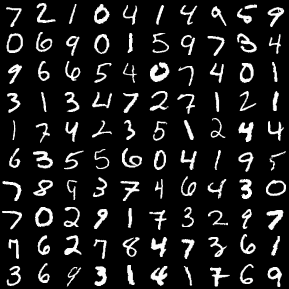

In [10]:
original_img = Image.fromarray(tile_raster_images(X=test_data,
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
original_img.save('delete_me.png')
print 'original'
I.display(I.Image('delete_me.png'))

B17 3.pkl


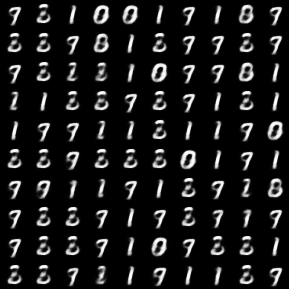

B20 3.pkl


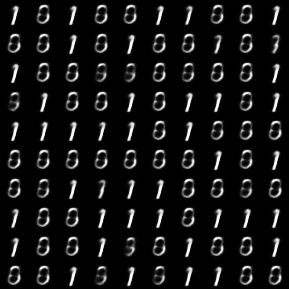

B17 finetune.pkl


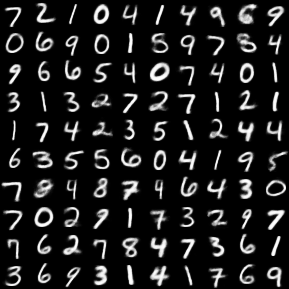

B20 finetune.pkl


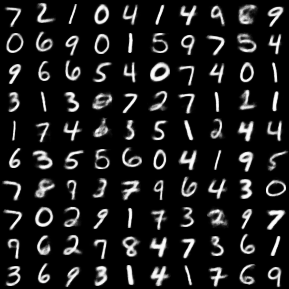

In [15]:
model_folders = ['B17','B20']
for submodel in ['3.pkl','finetune.pkl']: 
    for model_folder in model_folders:
        reconstructed = Image.fromarray(tile_raster_images(X=xhat[model_folder][submodel],
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
        reconstructed.save('delete_me.png')
        print model_folder, submodel
        I.display(I.Image('delete_me.png'))

In [ ]:
import cPickle as pickle
params = [pickle.load(open(os.path.join(dir_model,model_folder,'params.pkl'),'r')) for model_folder in model_folders]

In [ ]:
params